In [2]:
!nvidia-smi

Mon Mar 27 04:07:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install openmim>=0.2.1
#!mim install mmcv-full>=1.6.1
!pip install mmcv-full==1.7.0 -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
!pip install mmdet>=2.25.1
!pip install mmpose>=0.28.1
!pip install -U moviepy>=1.0.3
!git clone https://github.com/hysts/anime-face-detector

# from IPython.display import clear_output

# clear_output()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
fatal: destination path 'anime-face-detector' already exists and is not an empty directory.


If you encounter the following error in Colab, you can restart the runtime to execute the following cells correctly.

```
xtcocotools/_mask.pyx in init xtcocotools._mask()
ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject
```

In [4]:
%cd anime-face-detector

/content/anime-face-detector


In [10]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
addict                        2.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.1
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
catalogue                     2.0.8
cert

In [5]:
#@title import packages

import cv2
import matplotlib.pyplot as plt
import numpy as np

import anime_face_detector

/usr/local/lib/python3.9/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [5]:
!pip install numpy scipy numba --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [6]:
#@title Contour Definition

# https://github.com/hysts/anime-face-detector/blob/main/assets/landmarks.jpg
FACE_BOTTOM_OUTLINE = np.arange(0, 5)
LEFT_EYEBROW = np.arange(5, 8)
RIGHT_EYEBROW = np.arange(8, 11)
LEFT_EYE_TOP = np.arange(11, 14)
LEFT_EYE_BOTTOM = np.arange(14, 17)
RIGHT_EYE_TOP = np.arange(17, 20)
RIGHT_EYE_BOTTOM = np.arange(20, 23)
NOSE = np.array([23])
MOUTH_OUTLINE = np.arange(24, 28)

FACE_OUTLINE_LIST = [FACE_BOTTOM_OUTLINE, LEFT_EYEBROW, RIGHT_EYEBROW]
LEFT_EYE_LIST = [LEFT_EYE_TOP, LEFT_EYE_BOTTOM]
RIGHT_EYE_LIST = [RIGHT_EYE_TOP, RIGHT_EYE_BOTTOM]
NOSE_LIST = [NOSE]
MOUTH_OUTLINE_LIST = [MOUTH_OUTLINE]

# (indices, BGR color, is_closed)
CONTOURS = [
    (FACE_OUTLINE_LIST, (0, 170, 255), False),
    (LEFT_EYE_LIST, (50, 220, 255), False),
    (RIGHT_EYE_LIST, (50, 220, 255), False),
    (NOSE_LIST, (255, 30, 30), False),
    (MOUTH_OUTLINE_LIST, (255, 30, 30), True),
]

In [7]:
#@title Visualization Function


def visualize_box(image,
                  box,
                  score,
                  lt,
                  box_color=(0, 255, 0),
                  text_color=(255, 255, 255),
                  show_box_score=True):
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), box_color, lt)
    if not show_box_score:
        return
    cv2.putText(image,
                f'{round(score * 100, 2)}%', (box[0], box[1] - 2),
                0,
                lt / 2,
                text_color,
                thickness=max(lt, 1),
                lineType=cv2.LINE_AA)


def visualize_landmarks(image, pts, lt, landmark_score_threshold):
    for *pt, score in pts:
        pt = tuple(np.round(pt).astype(int))
        if score < landmark_score_threshold:
            color = (0, 255, 255)
        else:
            color = (0, 0, 255)
        cv2.circle(image, pt, lt, color, cv2.FILLED)


def draw_polyline(image, pts, color, closed, lt, skip_contour_with_low_score,
                  score_threshold):
    if skip_contour_with_low_score and (pts[:, 2] < score_threshold).any():
        return
    pts = np.round(pts[:, :2]).astype(int)
    cv2.polylines(image, np.array([pts], dtype=np.int32), closed, color, lt)


def visualize_contour(image, pts, lt, skip_contour_with_low_score,
                      score_threshold):
    for indices_list, color, closed in CONTOURS:
        for indices in indices_list:
            draw_polyline(image, pts[indices], color, closed, lt,
                          skip_contour_with_low_score, score_threshold)


def visualize(image: np.ndarray,
              preds: np.ndarray,
              face_score_threshold: float,
              landmark_score_threshold: float,
              show_box_score: bool = True,
              draw_contour: bool = True,
              skip_contour_with_low_score=False):
    res = image.copy()

    for pred in preds:
        box = pred['bbox']
        box, score = box[:4], box[4]
        box = np.round(box).astype(int)
        pred_pts = pred['keypoints']

        # line_thickness
        lt = max(2, int(3 * (box[2:] - box[:2]).max() / 256))

        visualize_box(res, box, score, lt, show_box_score=show_box_score)
        if draw_contour:
            visualize_contour(
                res,
                pred_pts,
                lt,
                skip_contour_with_low_score=skip_contour_with_low_score,
                score_threshold=landmark_score_threshold)
        visualize_landmarks(res, pred_pts, lt, landmark_score_threshold)

    return res

In [8]:
#@title Detector

device = 'cuda:0'  #@param ['cuda:0', 'cpu']
model = 'yolov3'  #@param ['yolov3', 'faster-rcnn']
detector = anime_face_detector.create_detector(model, device=device)

  0%|          | 0.00/235M [00:00<?, ?B/s]

  0%|          | 0.00/37.5M [00:00<?, ?B/s]

load checkpoint from local path: /root/.cache/torch/hub/checkpoints/mmpose_anime-face_hrnetv2.pth
load checkpoint from local path: /root/.cache/torch/hub/checkpoints/mmdet_anime-face_yolov3.pth


In [9]:
#@title Visualization Arguments

face_score_threshold = 0.5  #@param {type: 'slider', min: 0, max: 1, step:0.1}
landmark_score_threshold = 0.3  #@param {type: 'slider', min: 0, max: 1, step:0.1}
show_box_score = True  #@param {'type': 'boolean'}
draw_contour = True  #@param {'type': 'boolean'}
skip_contour_with_low_score = True  #@param {'type': 'boolean'}

# image test

In [10]:
image = cv2.imread('assets/input.jpg')
preds = detector(image)

/usr/local/lib/python3.9/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


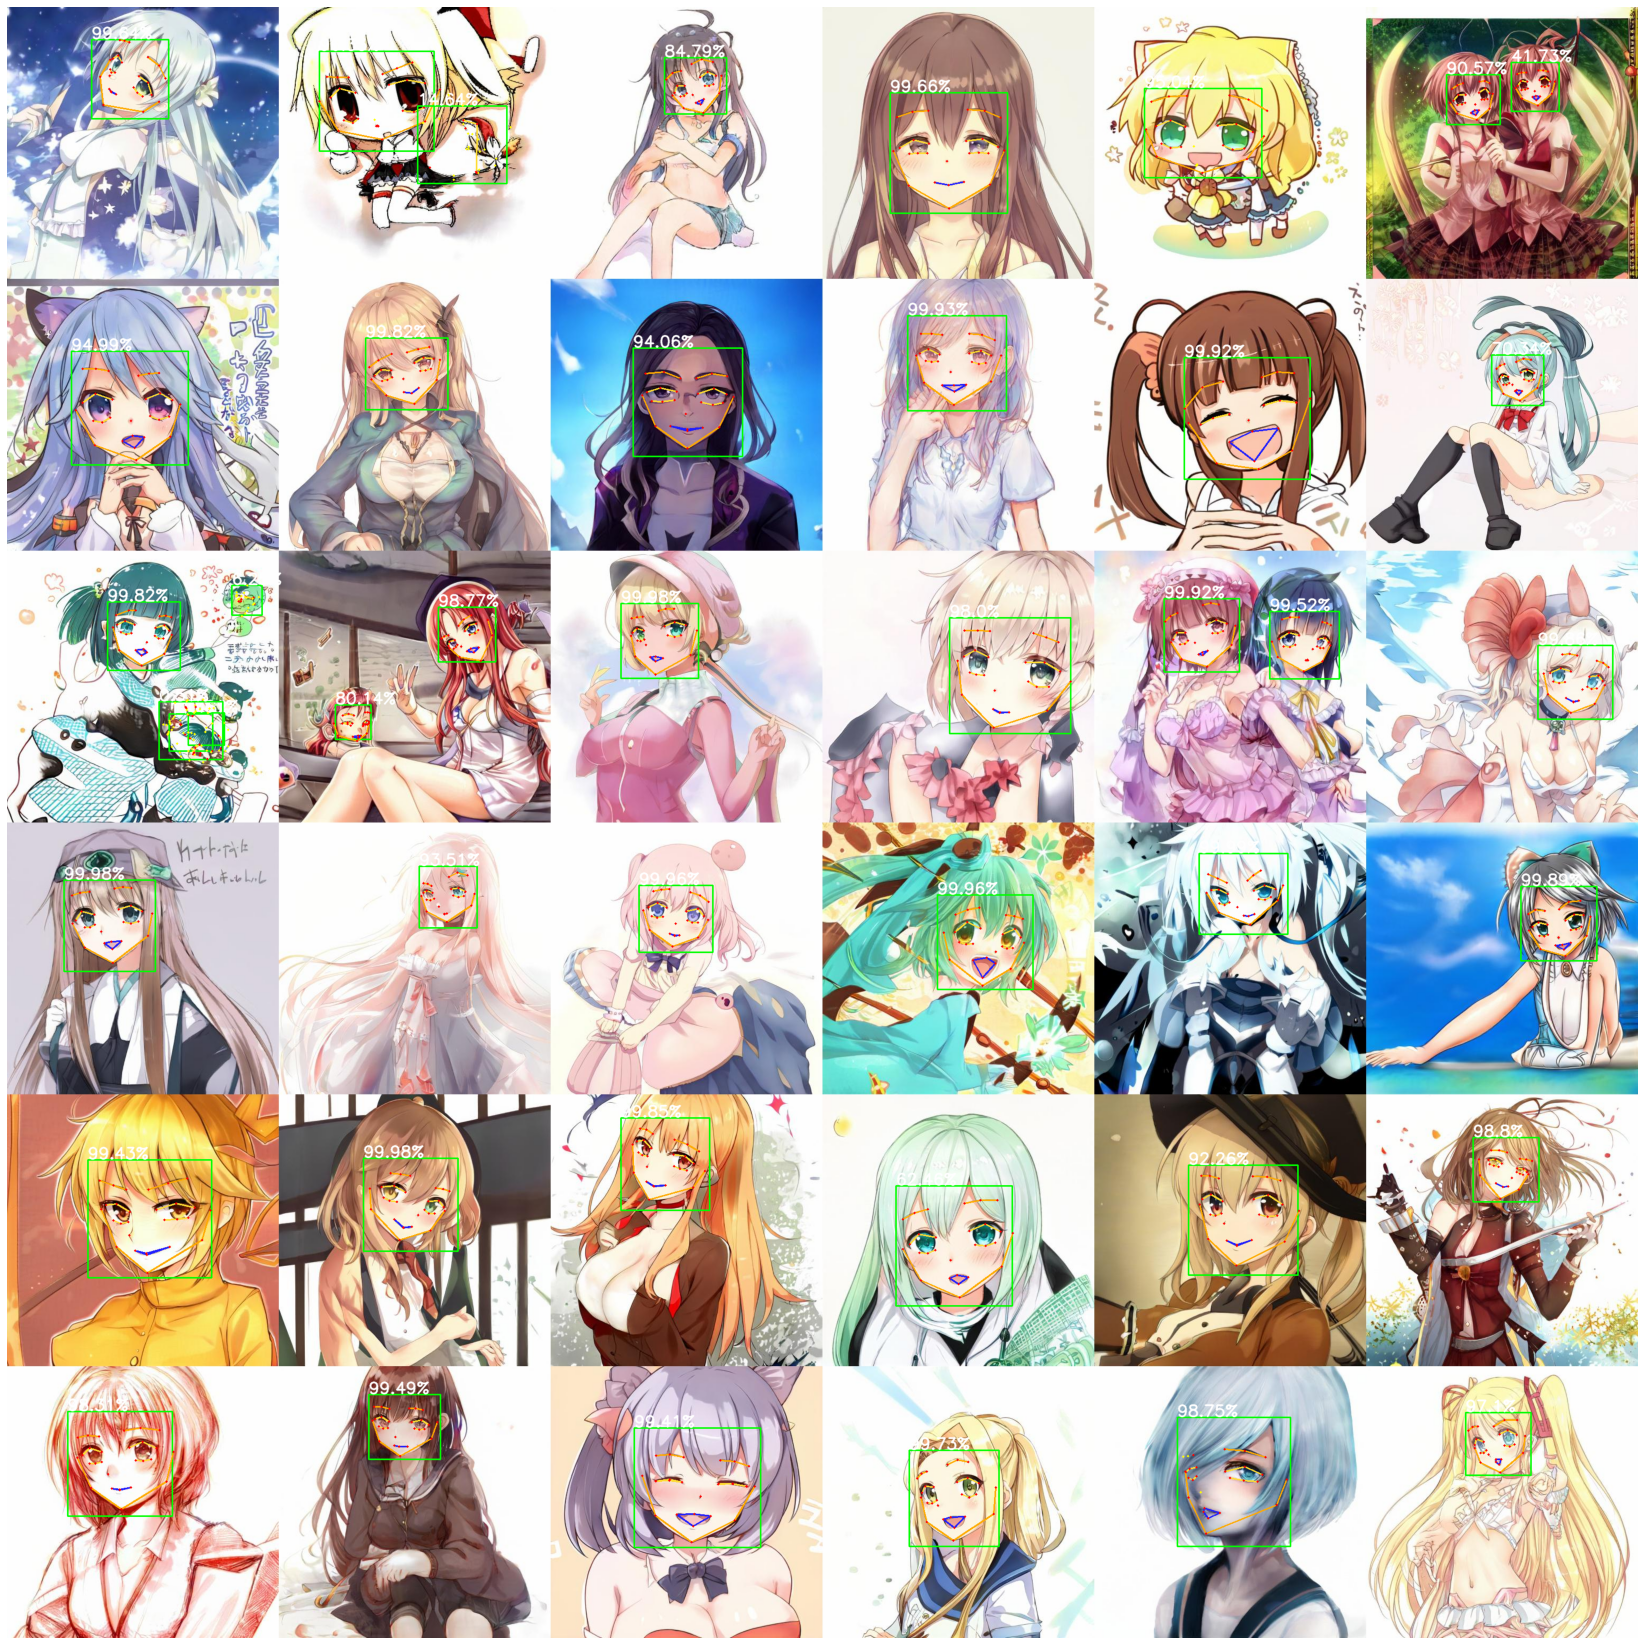

In [11]:
res = visualize(image, preds, face_score_threshold, landmark_score_threshold,
                show_box_score, draw_contour, skip_contour_with_low_score)

plt.figure(figsize=(30, 30))
plt.imshow(res[:, :, ::-1])
plt.axis('off')
plt.show()

# video test

In [12]:
# https://www.sakugabooru.com/post/show/43401
!wget -q https://www.sakugabooru.com/data/f47f699b9c5afc5a849be4b974f40975.mp4 -O input_vid.mp4

In [13]:
from moviepy.editor import VideoFileClip

# skip frame
speedx = 2
clip = VideoFileClip('input_vid.mp4').subfx(lambda c: c.speedx(speedx))
clip.write_videofile('input_vid_clip.mp4')
clip.close()

Moviepy - Building video input_vid_clip.mp4.
Moviepy - Writing video input_vid_clip.mp4



Moviepy - Done !
Moviepy - video ready input_vid_clip.mp4


In [14]:
from tqdm.auto import tqdm

cap = cv2.VideoCapture('input_vid_clip.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS) / speedx
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
writer = cv2.VideoWriter(
    filename='/content/anime-face-detector/output_vid.mp4',
    # some installation of opencv may not support x264 (due to its license),
    # you can try other format (e.g. MPEG)
    fourcc=cv2.VideoWriter_fourcc(*'MPEG'),
    fps=frames_per_second,
    frameSize=(width, height),
    isColor=True)

# Colab CPU 3.27s/it, Colab GPU 2.75it/s
with tqdm(total=num_frames) as pbar:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        pbar.update()
        preds = detector(frame)
        vis_frame = visualize(
            frame,
            preds,
            face_score_threshold=face_score_threshold,
            landmark_score_threshold=landmark_score_threshold,
            show_box_score=show_box_score,
            draw_contour=draw_contour,
            skip_contour_with_low_score=skip_contour_with_low_score)
        writer.write(vis_frame)

cap.release()
writer.release()

  0%|          | 0/22 [00:00<?, ?it/s]

In [15]:
!ffmpeg -i output_vid.mp4 -c:v libx264 -hide_banner -loglevel error -y out.mp4

In [16]:
from base64 import b64encode

from IPython.display import HTML

HTML(f"""
<video height=400 controls loop>
  <source src="data:video/mp4;base64,{b64encode(open('out.mp4','rb').read()).decode()}" type="video/mp4">
</video>
""")